In [1]:
import numpy as np
from tqdm import tqdm
import random, math
from matplotlib import pyplot as plt

def mean_squared_error(ytrue, ypred):
    return ((ytrue.reshape(-1) - ypred.reshape(-1))**2).mean()

def r2_score(ytrue, ypred):
    SSE=((ytrue.reshape(-1) - ypred.reshape(-1))**2).sum()
    SSTO=((ytrue.reshape(-1).mean() - ytrue.reshape(-1))**2).sum()
    return 1 - (SSE/SSTO)

class linear_reg:
    
    def __init__(self, alpha=0.001, C=50, preprocessors=[], patience=10):
        self.alpha=alpha
        self.C=C
        self.preprocessors=preprocessors
        self.patience=10
        pass
    
    def plot(self, r2s, losses):
        plt.style.use('dark_background')
        fig, ax =  plt.subplots(1,2, figsize=(10, 6))
        ax[0].plot(r2s, color='yellow')
        ax[0].set_title('R2 score Plot'), ax[0].set_xlabel('Epochs'), ax[0].set_ylabel('R2')
        ax[1].plot(losses, color='yellow')
        ax[1].set_title('Loss Plot'), ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('loss')
        plt.show()
        
    def computeCost(self, deviation):
        return (deviation**2).mean() + np.linalg.norm(self.params)**2/self.C
    
    def _gen_batch(self, batch_size, no_of_samples, *args):
        i=0
        for j in range(math.ceil(no_of_samples/batch_size)):
            yield [arg[i:min(i+batch_size, no_of_samples)] for arg in args]
            i+=batch_size   
            
    def earlystop(self, losses):
        if len(losses)<self.patience:
            return False
        return all(losses[-1] >= loss for loss in losses[-(self.patience+1):-1])
        
    def fit(self, X, y, epochs=100000, batch_size=128, plot=True):
        
        alpha=self.alpha
        C=self.C
               
        X=np.array(X)
        y=np.array(y)
        num_of_samples=len(y)
        
        for pp in self.preprocessors:
            X=pp.fit_transform(X)
            
        biased_X=np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        self.params=np.ones(X.shape[1]+1)*10 
        SSTO=((y-y.mean())**2).sum()
        
        r2scores, losses = [], []
        pbar=tqdm(range(epochs), position=0, leave=True)
        for epoch in pbar:
            
            indices=np.array(range(num_of_samples))
            random.shuffle(indices)
            biased_X = biased_X[indices]
            y = y[indices]
            
            for batch_biased_X, batch_y in self._gen_batch(batch_size, num_of_samples, biased_X, y):
                yhat=batch_biased_X.dot(self.params)
                deviation=yhat-batch_y
#                 cost=(deviation**2).mean()
                delta_params=(2/C)*self.params + 2*batch_biased_X.T.dot(deviation)/num_of_samples
                self.params=self.params-alpha*delta_params
        
            ypred=biased_X.dot(self.params)
            SSE=((ypred-y)**2).sum()
            r2=1-SSE/SSTO
            cur_cost=SSE/num_of_samples
            pbar.set_description("R2 {:.2f} MSE {:.2f}".format(r2, cur_cost))
            r2scores.append(r2), losses.append(cur_cost)
            if self.patience and self.earlystop(losses):
                print(f'Early stopping, loss traceback: {losses[-(self.patience+1):]}')
                break
        if plot:
            self.plot(r2scores, losses)
            
            
    def predict(self, Xpred):
        for pp in self.preprocessors:
            Xpred=pp.transform(Xpred)
        biased_Xpred=np.concatenate([np.ones((Xpred.shape[0], 1)), Xpred], axis=1)
        return biased_Xpred.dot(self.params)
    
    def score(self, predX, y_true):
        yhat=self.predict(predX)
        return r2_score(y_true, yhat)

R2 0.56 MSE 38.92:   9%|█████▏                                                  | 9169/100000 [00:23<03:52, 390.95it/s]


Early stopping, loss traceback: [38.91714169239367, 38.917141861138695, 38.91714075766898, 38.91714039933178, 38.91713958256904, 38.9171383823336, 38.91713948805577, 38.91713819120365, 38.91714014844063, 38.917141309207565, 38.91714235553759]


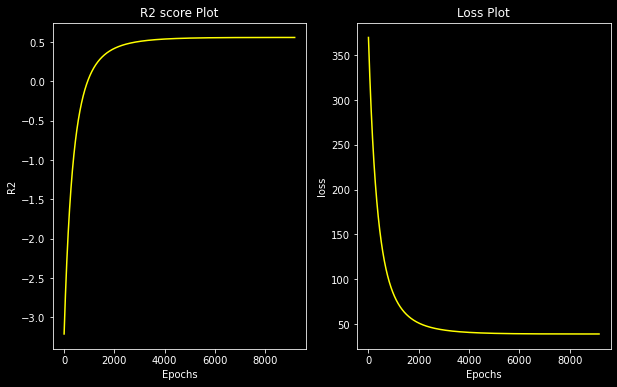

40.84332870623826 0.5569557260818501 0.41022454773614736


In [4]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X, y=load_boston(return_X_y=True)
trainX, testX, trainY, testY = train_test_split(X, y, random_state=28, test_size=0.2)

lr=linear_reg(preprocessors=[StandardScaler(), Normalizer()])
# lr=LinearRegression()
lr.fit(trainX, trainY)

pred=lr.predict(testX)
print(mean_squared_error(pred, testY), lr.score(trainX, trainY), lr.score(testX, testY))